In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
plt.style.use('seaborn-whitegrid')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


This data originally came from Crowdflower's [Data for Everyone library](http://www.crowdflower.com/data-for-everyone).

As the original source says,

> We looked through tens of thousands of tweets about the early August GOP debate in Ohio and asked contributors to do both sentiment analysis and data categorization. Contributors were asked which candidate was mentioned, and what the sentiment was for a given tweet. 

In [4]:
# load dataset 
tweets = pd.read_csv('input/Sentiment.csv', parse_dates=['tweet_created'])
tweets.sample(5)

,Unnamed: 0,id,candidate,sentiment,name,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
514,514,515,Ted Cruz,Positive,MaidmaeMarion,98,RT @RickCanton: #CruzCrew - the outsider. Alwa...,NaN,2015-08-07 09:50:45-07:00,629696190381068288,NaN,NaN
10758,10758,10759,No candidate mentioned,Negative,RWSurferGirl,157,It is very disappointing that Fox News is not ...,NaN,2015-08-06 19:50:06-07:00,629484634946940928,"Newport Beach, California",Pacific Time (US & Canada)
13022,13022,13023,No candidate mentioned,Negative,blckburn,0,Wait did he say Pimps and Prostitutes #GopDebates,NaN,2015-08-06 19:11:28-07:00,629474911782895616,"iPhone: 39.754280,-84.201958",Eastern Time (US & Canada)
1171,1171,1172,No candidate mentioned,Negative,LindaC528,390,RT @MarkDiStef: As an Australian watching the ...,NaN,2015-08-07 09:44:11-07:00,629694537028337665,S.W. Chicago suburbs,Central Time (US & Canada)
8402,8402,8403,Donald Trump,Neutral,sew_4th,72,"RT @larryelder: Trump should have said, ""Megyn...",NaN,2015-08-07 03:22:34-07:00,629598498292432896,NaN,Quito


In [ ]:
print(f"dataset contains {tweets.shape[0]} tweets and {tweets.shape[1]} predictor variables.")

dataset contains 13871 tweets and 12 predictor variables.


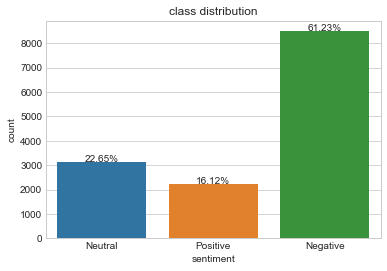

In [ ]:
plt.figure()
ax = plt.axes()
sns.countplot(tweets.sentiment)

total_tweets = len(tweets)
plt.title('class distribution')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+20,
            f'{int(height)/total_tweets:.2%}',
            ha="center", fontsize=10)
    
plt.show()

In [ ]:
contingency_table = pd.crosstab(tweets.candidate, tweets.sentiment)
contingency_table['negative_proportion'] = contingency_table.Negative/contingency_table.sum(axis=1)
contingency_table

sentiment,Negative,Neutral,Positive,negative_proportion
candidate,,,,
Ben Carson,186,54,164,0.460396
Chris Christie,218,42,33,0.744027
Donald Trump,1758,446,609,0.624956
Jeb Bush,589,72,44,0.835461
John Kasich,82,47,113,0.338843
Marco Rubio,105,51,119,0.381818
Mike Huckabee,237,83,73,0.603053
No candidate mentioned,4724,2087,680,0.630623
Rand Paul,148,60,55,0.562738


The candidate `Donald Trump` has the highest number of negative tweets. However, if we look at the total number of tweet per candidate we can see that `Jeb Bush` has almost 84% of the tweets mentionning him as negative.

**What kind of tweets are the most retweeted?**

In [ ]:
tweets.groupby('sentiment').sum()['retweet_count']

sentiment
Negative    419335.0
Neutral     117243.0
Positive     98760.0
Name: retweet_count, dtype: float64

Negative tweets are more than 4 times retweeted than positive tweets. 

**Who are the most retweeted candidates?**

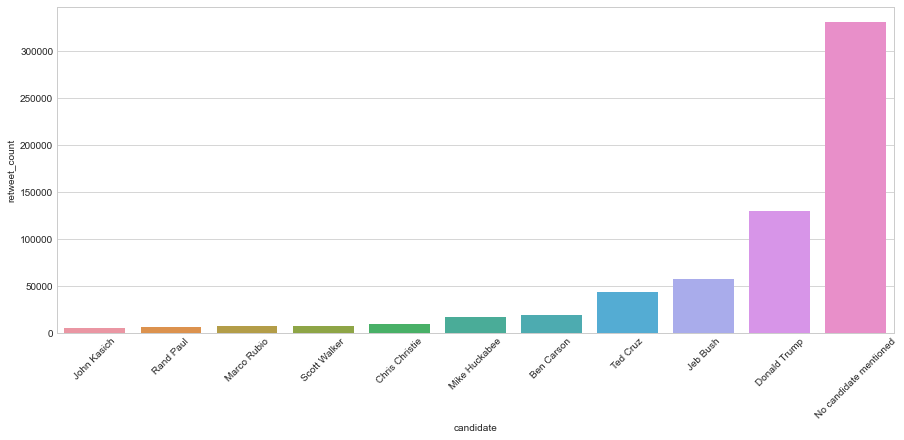

In [ ]:
most_rt_candidates = tweets.groupby('candidate').sum()['retweet_count'].sort_values()
plt.figure(figsize=(15,6))
sns.barplot(most_rt_candidates.index, most_rt_candidates)
plt.xticks(rotation=45)
plt.show()

Let us have a look at the time variable `tweet_created`

In [ ]:
start_date = tweets.tweet_created.sort_values().iloc[0]
end_date = tweets.tweet_created.sort_values().iloc[-1]
start_date, end_date, (end_date - start_date), start_date.day_name(), end_date.day_name()

(Timestamp('2015-08-06 17:44:53-0700', tz='pytz.FixedOffset(-420)'),
 Timestamp('2015-08-07 10:12:32-0700', tz='pytz.FixedOffset(-420)'),
 Timedelta('0 days 16:27:39'),
 'Thursday',
 'Friday')

We can conclude that the tweets recording lasted for 16hours and ~28 minute. The recodring started Thursday, august 2015 at 17:44 until friday, august 2015 at 10:12.

**How are tweets distributed accros the day? is there any time slot that has more tweets than others?**

In [ ]:
tweets_ordered_bytime = tweets.sort_values(by='tweet_created')

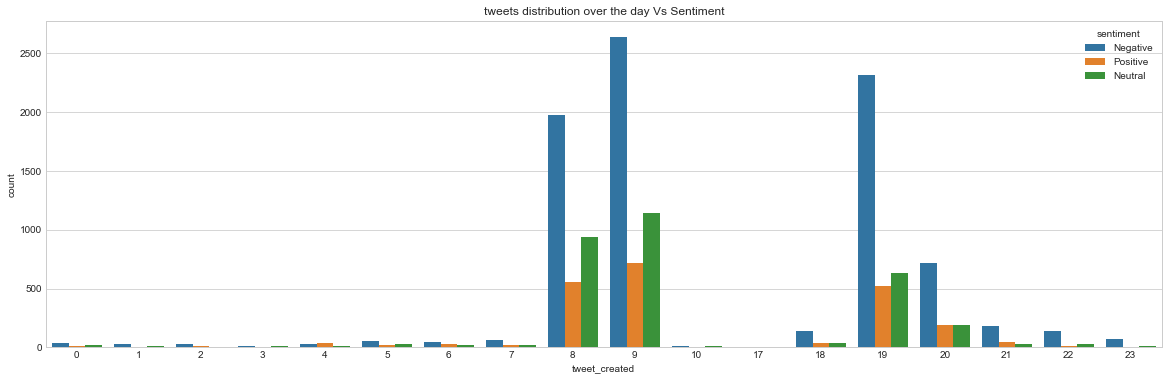

In [ ]:
plt.figure(figsize=(20,6))
sns.countplot(tweets_ordered_bytime.tweet_created.dt.hour, hue=tweets_ordered_bytime.sentiment)
plt.title('tweets distribution over the day Vs Sentiment')
plt.show()

We might one to add a new predictor variable that stores the hour of the day or maybe categorigal variable with the following enumeration: morning, afternoon, evening, night

## Missing values

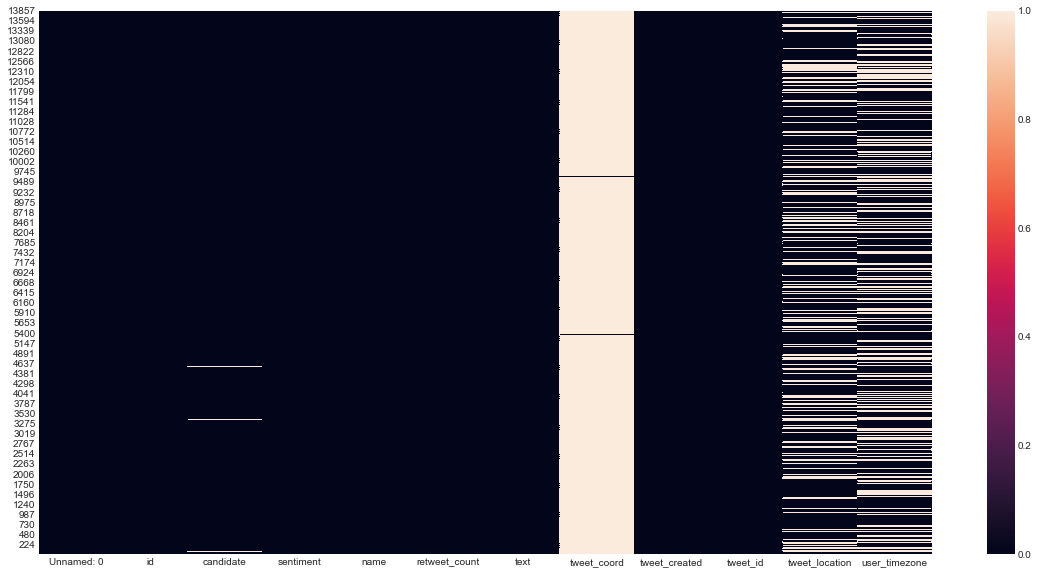

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(tweets_ordered_bytime.isna())
plt.show()

`Tweet_location` and `user_timezone` contain a lot of missing values.
- add new boolean is_nan + impuatation most freq ?

In [ ]:
tweets.tweet_location.isna().sum()/len(tweets), tweets.user_timezone.isna().sum()/len(tweets)

(0.28202725109941607, 0.3174248431980391)

Tweet_location and user_timezone are composed of neary 30% of missing of values.

In [ ]:
from scipy import stats

def is_feature_important(feature, target, alpha=.05):
    crosstable = pd.crosstab(target,feature) 
    chi2, p, dof, expected = stats.chi2_contingency(crosstable.values)
    
    return p < alpha

In [ ]:
is_feature_important(tweets.user_timezone, tweets.sentiment), is_feature_important(tweets.tweet_location, tweets.sentiment)

(True, True)

- Tweet_location and user_timezone are correlated with the target variable accorind to kh2 test of independance.

## Feature engineering

## Tweets text

Let's print some tweets and see how they look

In [ ]:
tweets.text.sample(2).to_list()

["RT @Nice1Parker: #GOPdebates where the bell doesn't mean a thing #dingdingding 😂",
 'RT @ckimbro927: Paul brilliantly got Christie to admit that he would violate the 4th Amendment. Of course, no one in that building cares. #…']

Before analyzing tweets some cleaning has to be performed:
- remove special caracters.
- remove links


In [5]:
tweets_cleaned = tweets.text.str.replace('RT', '').str.replace('@', '').str.replace('#', '')
tweets_cleaned = tweets_cleaned.str.replace(r'http[s]*\S+', '')

Let's use Spacy to create embeddings out of the tweets.

In [ ]:
import spacy 

nlp_md = spacy.load('en_core_web_md')

embeddings = []
for idx, text in tweets_cleaned.iteritems():
    embeddings.append(nlp_md(text).vector)
    print(f"progress {idx/len(tweets_cleaned):.2%}...", end='\r')

In [ ]:
# save embdeddings
np.save('embeddings', embeddings)

## tweet_created

let's create four categories out of tweet_created.

- Noon: from 6:00 to 12:00 
- Afternoon: from 12:01 to 17:00
- Evening: from 17:01 to 20:00
- Night: from 20:01 to 5:59

In [10]:
def mapping_func(hour):
    if 6 < hour <= 12:
        return 'Noon'
    elif 12 < hour <= 17:
        return 'Afternoon'
    elif 17 < hour <= 20:
        return 'Evening' 
    else:
        return 'Night'
period_of_day = tweets.tweet_created.dt.hour.apply(mapping_func)

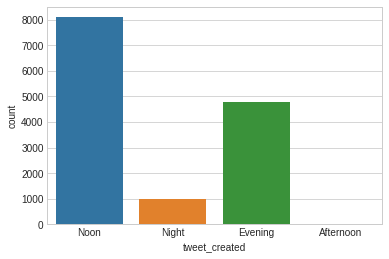

In [11]:
sns.countplot(period_of_day);

## Sentiment

Let's encode our classes into numerical values.

In [12]:
from sklearn.preprocessing import LabelEncoder

target_encoder = LabelEncoder()
y = pd.Series(target_encoder.fit_transform(tweets.sentiment))

As we saw in EDA ~30% of these two features is composed of missing values. Let's consider the missing value as another category therefore we will impute it -999.

Let's create two other feature, user_timezone_isna and tweet_location_isna which will hold a boolean value to indictate to the model the rows containing missing values respectively for user_timezone and tweet_location.

In [13]:
tweets['user_timezone_isna'] = tweets.user_timezone.isna().astype(int)
tweets['tweet_location_isna'] = tweets.tweet_location.isna().astype(int)
tweets['user_timezone'] = tweets.user_timezone.fillna(-999)
tweets['tweet_location'] = tweets.tweet_location.fillna(-999)

## Candidate

In [14]:
tweets.candidate.isna().sum()

96

In [15]:
tweets.candidate.value_counts()

No candidate mentioned    7491
Donald Trump              2813
Jeb Bush                   705
Ted Cruz                   637
Ben Carson                 404
Mike Huckabee              393
Chris Christie             293
Marco Rubio                275
Rand Paul                  263
Scott Walker               259
John Kasich                242
Name: candidate, dtype: int64

When a candidate is not mentionned, the tweet is put in 'No candidate mentioned'. Therefore, I will consider the missing candidate values to be part of 'No candidate mentioned' category.

In [16]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
tweets['candidate'] = imputer.fit_transform(tweets['candidate'].values.reshape(-1, 1))

## Data split

Our final dataset will be composed of the following features: user_timezone_isna, tweet_location_isna, user_timezone, tweet_location, text embeddings, retweet_count and candidate

In [18]:
boolean_features = ['user_timezone_isna', 'tweet_location_isna']
categorical_features = ['candidate', 'user_timezone', 'tweet_location']
numerical_features = ['retweet_count']

# word embeddings dataframe
prefix = 'embed_'
embeddings_col = [prefix+str(col) for col in range(300)]
embeddings = pd.DataFrame(embeddings, columns=embeddings_col)

data = pd.concat((tweets[boolean_features + numerical_features + categorical_features],
                  embeddings), axis=1)

In [19]:
from sklearn.model_selection import train_test_split

SEED = 42

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=.2,
                               stratify=y, random_state=SEED)

# Pipeline

For the categorical variable, I suggest that we count encode them. Basically we will replace each categorie by it's number of occurences.

In [20]:
from sklearn.base import BaseEstimator
class CountEncoder(BaseEstimator):

    def __init__(self, normalize=True):
        self.normalize = normalize

    def fit(self, X_train, y=None):
        self.__set_mapping(X_train)
        
        return self

    def transform(self, X):
        X_tr = X.copy()

        if type(X) != type(pd.DataFrame()): 
            raise ValueError(f'{type(X)} not supported')
        
        col_id = 0
        for col, serie in  X.iteritems():
            X_tr[col] = serie.map(self.mapping_list[col_id])
            col_id += 1
        
        return X_tr

    def __set_mapping(self, X):
        if type(X) != type(pd.DataFrame()):
            raise ValueError(f'{type(X)} not supported')

        self.mapping_list = []
        for col, serie in X.iteritems():
            if self.normalize:
                self.mapping_list.append((serie.value_counts()/serie.value_counts().max()).to_dict())
            else:
                self.mapping_list.append(serie.value_counts().to_dict())

In [35]:
from sklearn.model_selection import StratifiedKFold

from hyperopt import fmin, hp, tpe, Trials, space_eval
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb

static_params = {
    'objective': 'multiclass',
    'boosting_type': 'gbdt',
    'num_class': 3,
    'metric': 'multi_logloss',
    'tree_method': 'gpu_hist',
    'max_depth': 5
}

def my_pipeline(hps): 
    feature_engineering = ColumnTransformer([('CountEncoder', CountEncoder(), categorical_features),
                                             ('PCA', PCA(n_components=0.8), embeddings_col)],
                                             remainder='passthrough', verbose=0)
    
    steps = [('feature_engineering', feature_engineering),
             ('model', lgb.LGBMClassifier(**static_params, **hps))
            ]

    model = Pipeline(steps)
    
    return model

hp_space = {
    'model': {        
        'learning_rate': hp.loguniform('eta', -5*np.log(10), np.log(0.2)),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1)
    }
}

def objective_func(hps):
    model = my_pipeline(hps['model'])
    n_splits = 5
    cv = StratifiedKFold(n_splits = n_splits)
    score_sum = 0
    print('----- new run -------------------------------------------')
    print('New parameters to be evaluated')
    print(hps)

    results = cross_validate(model, X_train, y=y_train, scoring='f1_macro', cv=cv, return_train_score=True)

    train = results['train_score'].mean()
    validation = results['test_score'].mean()
        
        
    print(f'---------------- F1 score: train-score: {train}, val-score: {validation} -----------')   
    return - validation

# Cross validation

In [36]:
trials = Trials()

best_clf1 = fmin(objective_func,
                 hp_space, algo=tpe.suggest, max_evals=10, 
                 trials=trials, rstate=np.random.RandomState(SEED))

----- new run -------------------------------------------
New parameters to be evaluated
{'model': {'colsample_bytree': 0.5345256704368021, 'learning_rate': 0.038121970973123157, 'subsample': 0.7273505261106861}}
---------------- F1 score: train-score: 0.6377738823773818, val-score: 0.5195310711232743 -----------
----- new run -------------------------------------------
New parameters to be evaluated
{'model': {'colsample_bytree': 0.9664339994239168, 'learning_rate': 0.01348870479297314, 'subsample': 0.7050519794266569}}
---------------- F1 score: train-score: 0.4452219322144499, val-score: 0.3936200673388021 -----------
----- new run -------------------------------------------
New parameters to be evaluated
{'model': {'colsample_bytree': 0.6517050549420875, 'learning_rate': 0.06297461247065016, 'subsample': 0.9186941777766421}}
---------------- F1 score: train-score: 0.7184797911329291, val-score: 0.5608678699342298 -----------
----- new run -------------------------------------------

The performance in the cross validation is very bad, it could be that the the number of samples is not sufficient for the model to perform better. 

options to explore to improve the model performance:

- create synthtic tweets or scrappe more tweets and label them.
- feature engineering
- topic modeling ?